<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/02-bow%2Blr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline JAIIO: BoW+Regresión Logística

En esta notebook se presetan los experimentos sobre la estrategia de representación y técnica de aprendizaje *baseline* utilizada para las 50 JAIIO.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Regresión logística para quedarnos con los vectores de coeficientes como indicador de las _features_ importantes.


## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [4]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/'
TRAIN_FILE = 'correos-train-80.csv'
TEST_FILE = 'correos-test-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['Consulta'] = pd.Series(preprocesar_correos(train_df['Consulta']))
test_df['Consulta'] = pd.Series(preprocesar_correos(test_df['Consulta']))

# Cambio los integers por las etiquetas
train_df['clase'] = etiquetas[train_df['clase']]
test_df['clase'] = etiquetas[test_df['clase']]

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))


El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 20 clases: ['Inscripción a Cursadas' 'Cambio de Carrera' 'Reincorporación'
 'Ingreso a la Universidad' 'Boleto Universitario'
 'Pedido de Certificados' 'Exámenes' 'Requisitos de Ingreso' 'Cursadas'
 'Situación Académica' 'Vacunas Enfermería' 'Consulta por Legajo'
 'Problemas con la Clave' 'Consulta sobre Título Universitario'
 'Certificados Web' 'Carga de Notas' 'Otras Consultas'
 'Cambio de Comisión' 'Consulta por Equivalencias' 'Datos Personales'].


## Regresión Logística

Se carga en memoria la función _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __LR__ y _representacion_documentos_ con la generación de las diferentes representaciones:

In [5]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [6]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BOW', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
modelo = 'LR'
# Defino los parámetros para GridSearchCV
params_lr = {'LR__C': [0.001, 0.01, 0.1, 1, 10, 100]}

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [7]:
for estrategia in estrategias_representacion:
  # Llamo a la función que realiza el gridsearch por estrategia  
  gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_lr, False)

Estrategia de representación: BOW
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.9s finished


Mounted at drive
Estrategia de representación: BOW
Parámetros: {'LR__C': 100, 'clasificador': 'LR', 'estrategia': 'BOW', 'accuracy': 0.715, 'precision': 0.389478354978355, 'recall': 0.3792313699893487, 'f1_score': 0.3728233145534763}
Accuracy Test-Set: 0.715
Estrategia de representación: TFIDF
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.6s finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: TFIDF
Parámetros: {'LR__C': 10, 'clasificador': 'LR', 'estrategia': 'TFIDF', 'accuracy': 0.72, 'precision': 0.4068827967100959, 'recall': 0.36212746473384766, 'f1_score': 0.3646011844973317}
Accuracy Test-Set: 0.72
Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'LR__C': 100, 'clasificador': 'LR', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.745, 'precision': 0.5089569545984778, 'recall': 0.45324162834801135, 'f1_score': 0.45779862701271756}
Accuracy Test-Set: 0.745
Estrategia de representación: 1-2-NGRAM-WORDS
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: 1-2-NGRAM-WORDS
Parámetros: {'LR__C': 100, 'clasificador': 'LR', 'estrategia': '1-2-NGRAM-WORDS', 'accuracy': 0.695, 'precision': 0.27858767576509513, 'recall': 0.26683137193775497, 'f1_score': 0.26165717297351376}
Accuracy Test-Set: 0.695


### Vector de coeficientes

Pongo en memoria la función para representación de documentos del repositorio del proyecto:

In [8]:
from funciones_dataset import consolidar_df
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Genero la representación de documentos
correos_train_vec, correos_test_vec = representacion_documentos(train_df['Consulta'], test_df['Consulta'], 'TFIDF', None)

# Separo en x e y - train y test- (además consolido feature estáticas con dinámicas)
x_train, y_train = consolidar_df(train_df, correos_train_vec, 'Consulta', 'clase')
x_test, y_test = consolidar_df(test_df, correos_test_vec, 'Consulta', 'clase')
  
# Escalado de datos: Se probó scale y MinMaxScaler y dió mejores resultados el último
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# Instancio y entreno el modelo
clf = LogisticRegression(C=1)
clf.fit(x_train_scaled, y_train)

# Se realizan las predicciones sobre el conjunto de validación
y_predictions = clf.predict(x_test_scaled) 

# Calculo el accuracy sobre test
acc_test = accuracy_score(y_test, y_predictions)

print('Accuracy Test-Set: {}' . format(acc_test))

Accuracy Test-Set: 0.735


Ahora se retornan los vectores de coeficientes para las clases:

In [9]:
clf.coef_

array([[-0.26092636, -0.17134615,  0.06919925, ...,  0.00457866,
         0.23759204, -0.05691558],
       [-0.04379699,  0.13972281,  0.04787484, ..., -0.0030552 ,
        -0.00599442, -0.00455262],
       [ 0.68405796,  0.03465707, -0.2222312 , ..., -0.00170655,
        -0.01043419, -0.0153068 ],
       ...,
       [-0.22830639,  0.25598577,  0.0511226 , ..., -0.02121121,
        -0.04902782, -0.04621407],
       [ 0.14625205, -0.31811779, -0.05559689, ..., -0.00068854,
        -0.00688038, -0.0113278 ],
       [-0.00161405,  0.41018051, -0.17713758, ..., -0.00071854,
        -0.00774888, -0.00531977]])

In [10]:
!pip install mglearn

     |████████████████████████████████| 542kB 4.0MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=f0a9ae3e307c6e41ed62baf4ec654c5d6a1cb89bbf45551ed93079f45c99fd0e
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn




		Gráfico de ponderación de coeficientes de la LR para la clase Cambio de Carrera


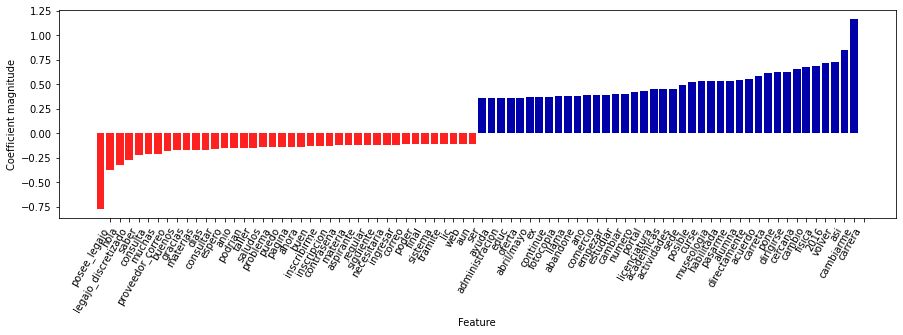



		Gráfico de ponderación de coeficientes de la LR para la clase Cambio de Comisión


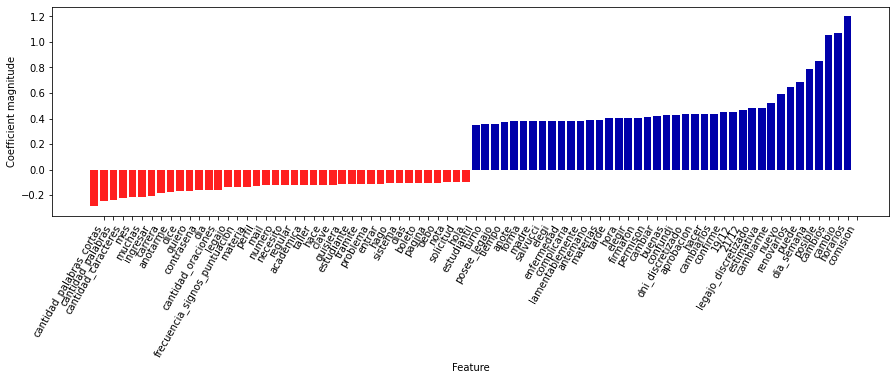



		Gráfico de ponderación de coeficientes de la LR para la clase Carga de Notas


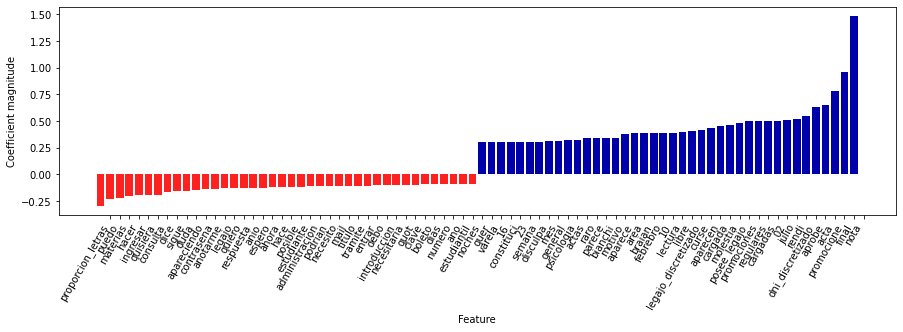



		Gráfico de ponderación de coeficientes de la LR para la clase Certificados Web


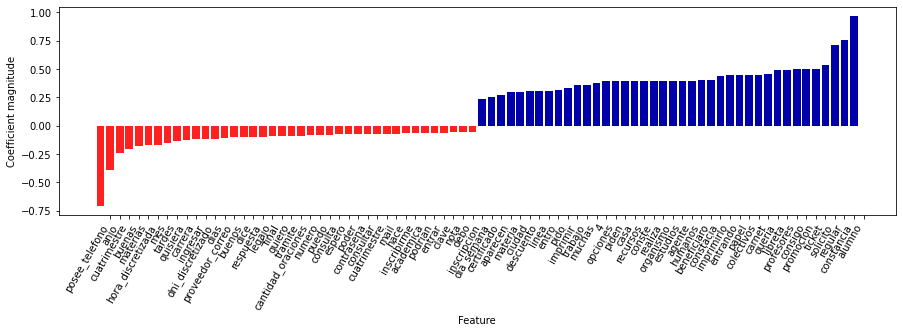



		Gráfico de ponderación de coeficientes de la LR para la clase Consulta por Equivalencias


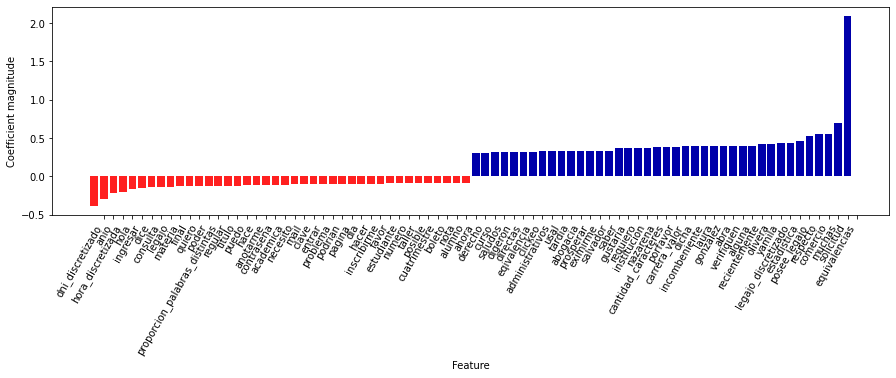



		Gráfico de ponderación de coeficientes de la LR para la clase Consulta por Legajo


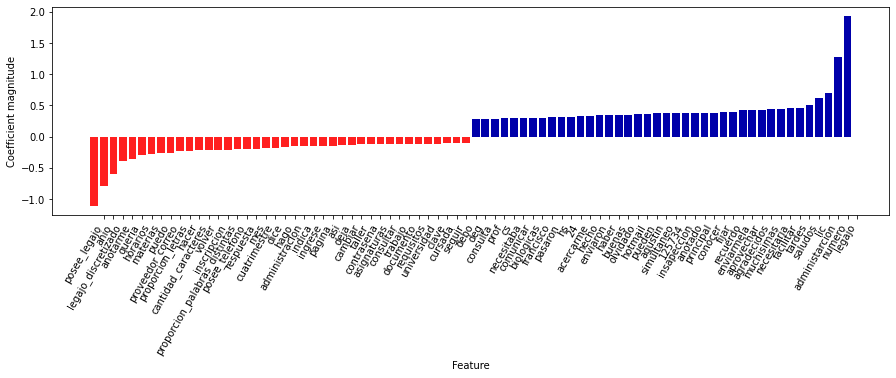



		Gráfico de ponderación de coeficientes de la LR para la clase Consulta sobre Título Universitario


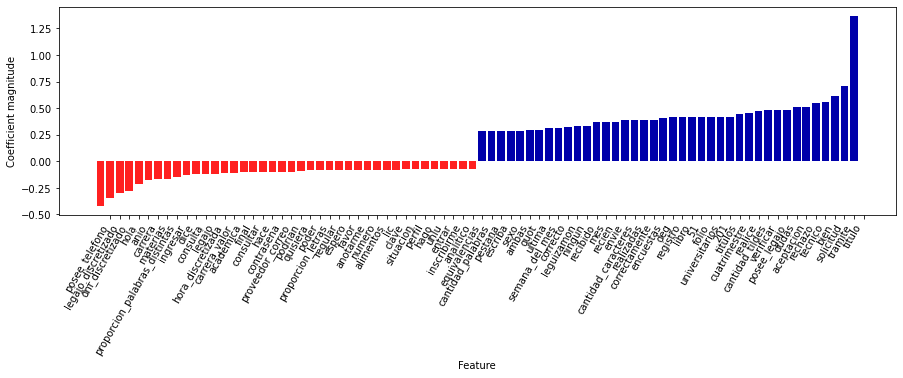



		Gráfico de ponderación de coeficientes de la LR para la clase Cursadas


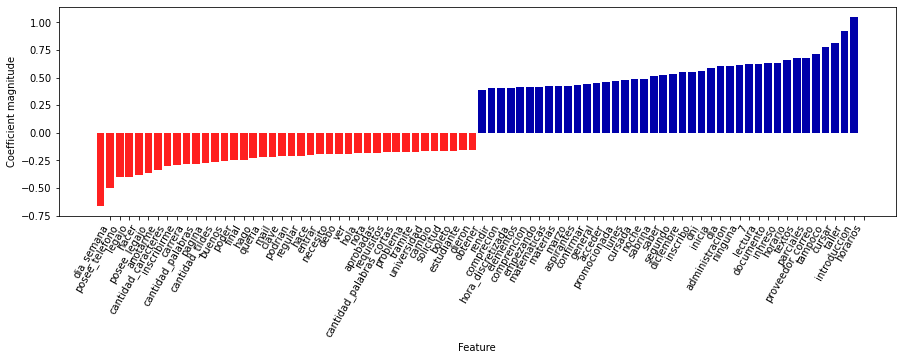



		Gráfico de ponderación de coeficientes de la LR para la clase Datos Personales


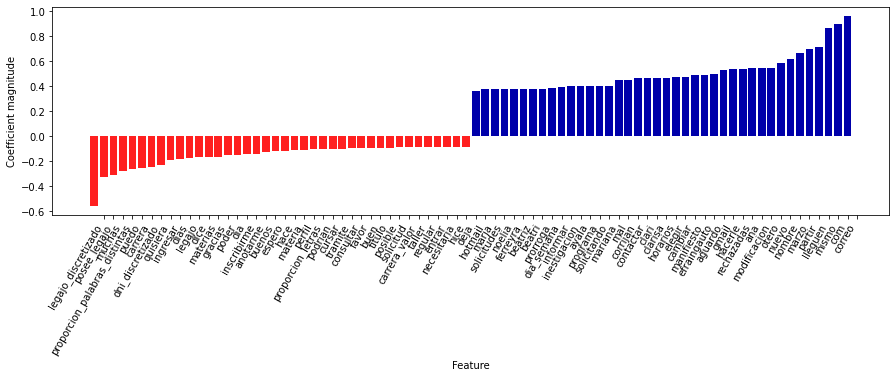



		Gráfico de ponderación de coeficientes de la LR para la clase Exámenes


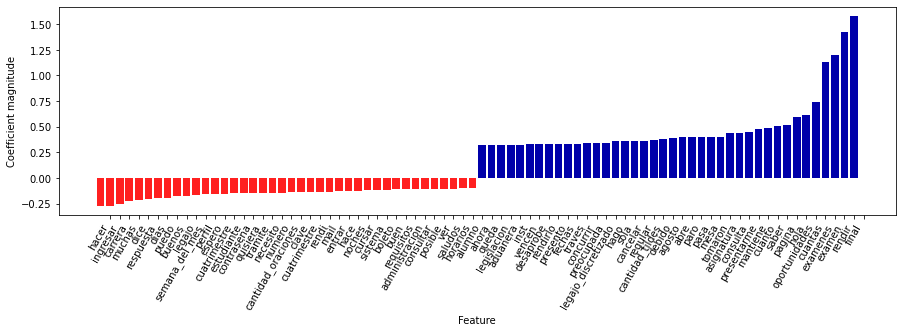



		Gráfico de ponderación de coeficientes de la LR para la clase Ingreso a la Universidad


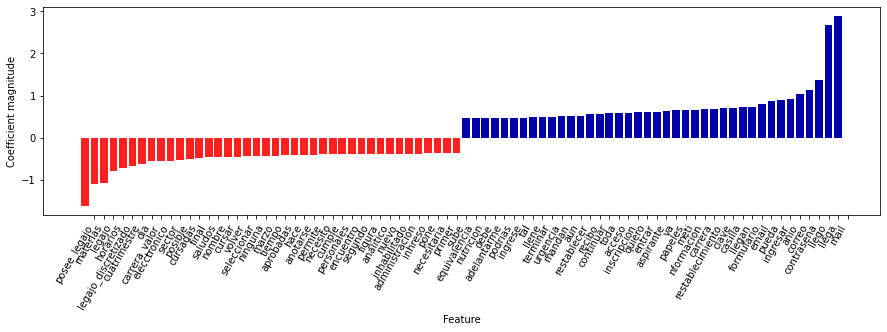



		Gráfico de ponderación de coeficientes de la LR para la clase Inscripción a Cursadas


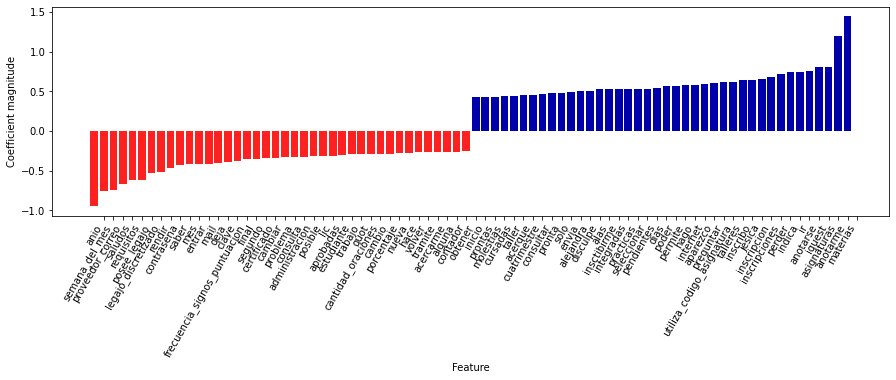



		Gráfico de ponderación de coeficientes de la LR para la clase Pedido de Certificados


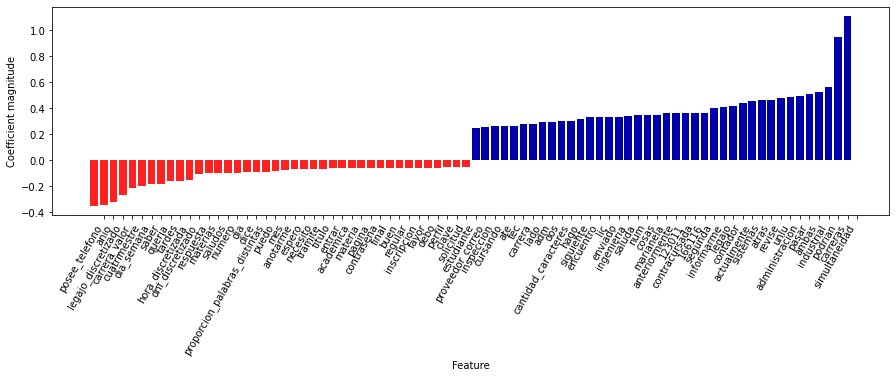



		Gráfico de ponderación de coeficientes de la LR para la clase Problemas con la Clave


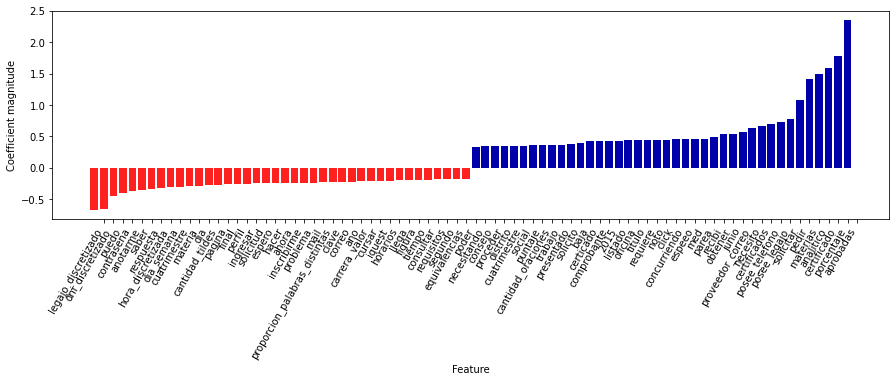



		Gráfico de ponderación de coeficientes de la LR para la clase Reincorporación


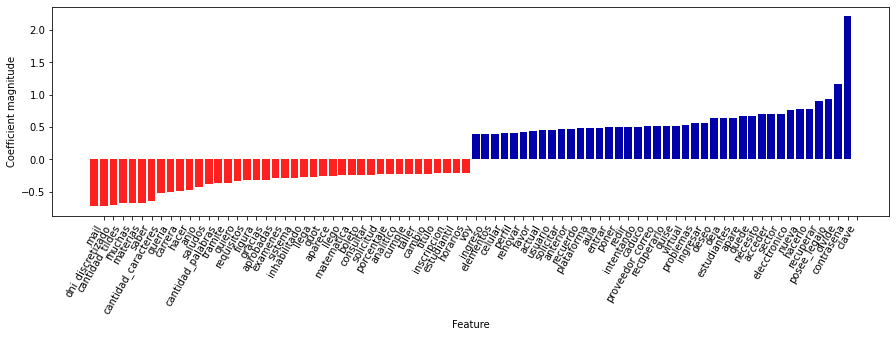



		Gráfico de ponderación de coeficientes de la LR para la clase Requisitos de Ingreso


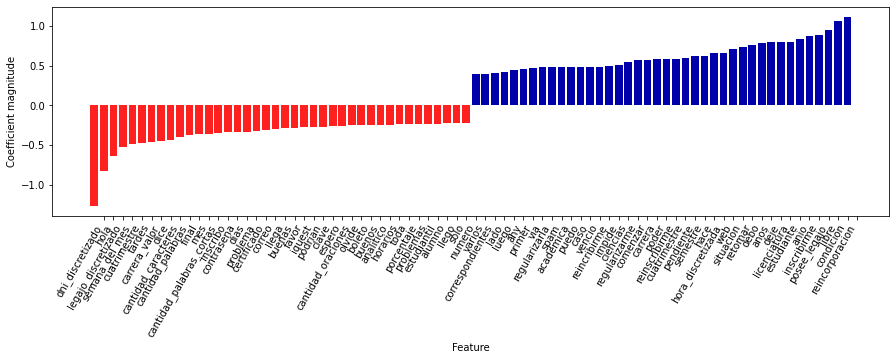



		Gráfico de ponderación de coeficientes de la LR para la clase Simultaneidad de Carreras


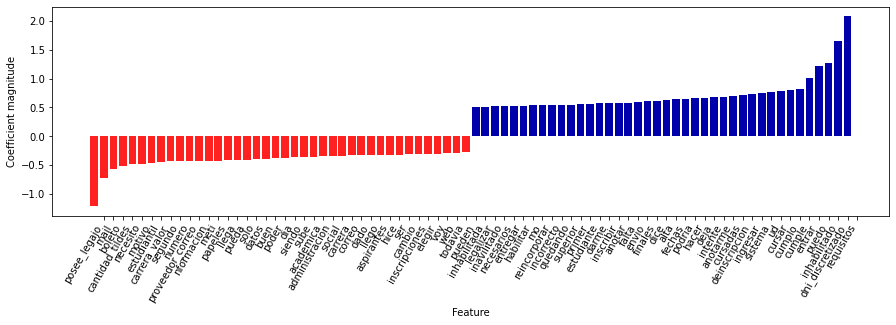



		Gráfico de ponderación de coeficientes de la LR para la clase Situación Académica


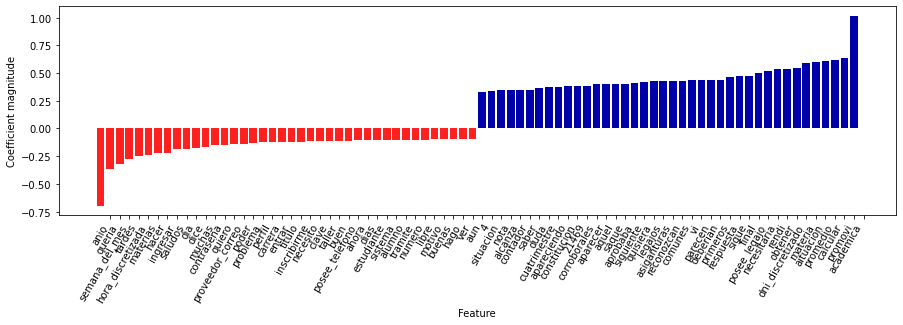



		Gráfico de ponderación de coeficientes de la LR para la clase Vacunas Enfermería


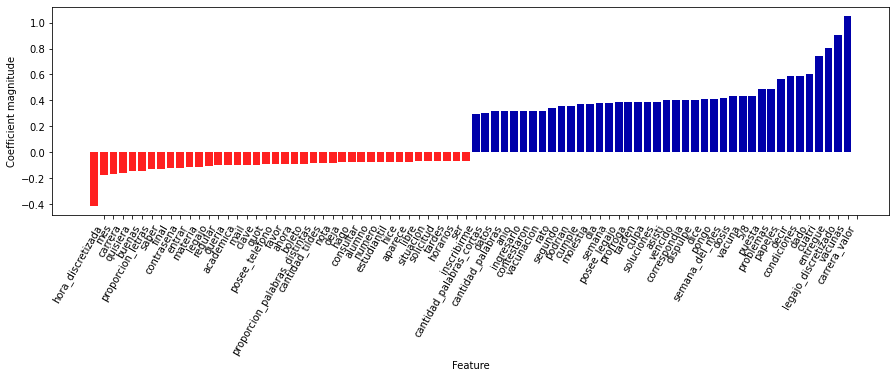

In [24]:
from mglearn.tools import visualize_coefficients
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(1, len(etiquetas)-1):
  print(f'\n\n\t\tGráfico de ponderación de coeficientes de la LR para la clase {etiquetas[i]}')
  visualize_coefficients(clf.coef_[i], x_train.columns, n_top_features=40)
  # Muestro el gráfico
  plt.show()

# Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05